<a href="https://colab.research.google.com/github/dcpatton/NLP/blob/master/Friends_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
seed = 51
random.seed(seed)

# Data Loading and Prep

In [2]:
from google.colab import files
uploaded = files.upload()

Saving friends_test.json to friends_test.json
Saving friends_dev.json to friends_dev.json
Saving friends_train.json to friends_train.json


In [3]:
import pandas as pd

df = pd.read_json('friends_train.json')
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,"{'speaker': 'Chandler', 'utterance': 'also I w...","{'speaker': 'The Interviewer', 'utterance': 'Y...","{'speaker': 'Chandler', 'utterance': 'That I d...","{'speaker': 'The Interviewer', 'utterance': 'S...","{'speaker': 'Chandler', 'utterance': 'My dutie...","{'speaker': 'The Interviewer', 'utterance': 'N...","{'speaker': 'Chandler', 'utterance': 'I see.',...","{'speaker': 'The Interviewer', 'utterance': 'B...","{'speaker': 'Chandler', 'utterance': 'Good to ...","{'speaker': 'The Interviewer', 'utterance': 'W...","{'speaker': 'Chandler', 'utterance': 'No dont...","{'speaker': 'The Interviewer', 'utterance': 'A...","{'speaker': 'Chandler', 'utterance': 'Really?!...","{'speaker': 'The Interviewer', 'utterance': 'A...","{'speaker': 'Joey', 'utterance': 'But then who...","{'speaker': 'Rachel', 'utterance': 'You know? ...","{'speaker': 'Joey', 'utterance': 'No-no-no-no,...","{'speaker': 'Rachel', 'utterance': 'No, I-I-I-...","{'speaker': 'Joey', 'utterance': 'Ok!', 'emoti...","{'speaker': 'Joey', 'utterance': 'All right, w...","{'speaker': 'Joey', 'utterance': 'I'm gonna se...","{'speaker': 'Joey', 'utterance': 'I'll see you...","{'speaker': 'Rachel', 'utterance': 'Yeah, sure...",None
1,"{'speaker': 'Chandler', 'utterance': 'Hey, Mon...","{'speaker': 'Monica', 'utterance': 'Hey-hey-he...","{'speaker': 'Chandler', 'utterance': 'Do I eve...","{'speaker': 'Monica', 'utterance': 'Chris says...","{'speaker': 'Chandler', 'utterance': 'No way!'...","{'speaker': 'Monica', 'utterance': 'Yeah, appa...","{'speaker': 'Chandler', 'utterance': 'Just cof...","{'speaker': 'Monica', 'utterance': 'Got me.', ...","{'speaker': 'Chandler', 'utterance': 'Can I ge...","{'speaker': 'Monica', 'utterance': 'Hey, did y...","{'speaker': 'Chandler', 'utterance': 'You betc...","{'speaker': 'Monica', 'utterance': 'Is it the ...","{'speaker': 'Chandler', 'utterance': 'Um-mm, y...","{'speaker': 'Phoebe', 'utterance': 'Oh my God,...","{'speaker': 'Chandler', 'utterance': 'What, wh...","{'speaker': 'Phoebe', 'utterance': 'What?!', '...","{'speaker': 'Phoebe', 'utterance': 'He was wit...","{'speaker': 'Phoebe', 'utterance': 'Look, 'My...","{'speaker': 'Phoebe', 'utterance': 'Now that I...","{'speaker': 'Phoebe', 'utterance': 'He thinks ...","{'speaker': 'Chandler', 'utterance': 'You real...","{'speaker': 'Phoebe', 'utterance': 'Oh, totall...","{'speaker': 'Joey', 'utterance': 'Done.', 'emo...",None
2,"{'speaker': 'Rachel', 'utterance': 'Hey!', 'em...","{'speaker': 'Ross', 'utterance': 'Hi!', 'emoti...","{'speaker': 'Rachel', 'utterance': 'What are y...","{'speaker': 'Ross', 'utterance': 'Ah y'know, t...","{'speaker': 'Rachel', 'utterance': 'Oh.', 'emo...","{'speaker': 'Ross', 'utterance': 'Hi.', 'emoti...","{'speaker': 'Rachel', 'utterance': 'Hi.', 'emo...","{'speaker': 'Ross', 'utterance': 'Howd did it...","{'speaker': 'Rachel', 'utterance': 'Oh well, t...","{'speaker': 'Ross', 'utterance': 'Im so proud...","{'speaker': 'Rachel', 'utterance': 'Me too!', ...","{'speaker': 'Ross', 'utterance': 'Listen, Im ...","{'speaker': 'Rachel', 'utterance': 'I know.', ...","{'speaker': 'Ross', 'utterance': 'Yeah.', 'emo...","{'speaker': 'Rachel', 'utterance': 'Yeah.', 'e...","{'speaker': 'Phoebe', 'utterance': 'Ameri-can....","{'speaker': 'Sergei', 'utterance': 'Ameri-ccan...","{'speaker': 'Phoebe', 'utterance': 'Ameri-can....","{'speaker': 'Sergei', 'utterance': 'Everybody!...",None,None,None,None,None
3,"{'speaker': 'Chandler', 'utterance': 'Good job...","{'speaker': 'Joey', 'utterance': 'You liked it...","{'speaker': 'Chandler', 'utterance': 'Oh-ho-ho...","{'speaker': 'Joey', 'utterance': 'Which part e...","{'speaker': 'Chandler', 'utterance': 'The whol...","{'speaker': 'Joey', 'utterance': 'Oh no-no-no,...","{'speaker': 'Chandler', 'utterance': 'I love t...","{'speaker': 'Joey', 'utterance': 'Hey, what ab...","{'speaker': 'Chandler', 'utterance': 'I was su...","{'speaker': 'Joey', 'utterance': 'You fell asl

In [4]:
df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,"{'speaker': 'Chandler', 'utterance': 'also I w...","{'speaker': 'The Interviewer', 'utterance': 'Y...","{'speaker': 'Chandler', 'utterance': 'That I d...","{'speaker': 'The Interviewer', 'utterance': 'S...","{'speaker': 'Chandler', 'utterance': 'My dutie...","{'speaker': 'The Interviewer', 'utterance': 'N...","{'speaker': 'Chandler', 'utterance': 'I see.',...","{'speaker': 'The Interviewer', 'utterance': 'B...","{'speaker': 'Chandler', 'utterance': 'Good to ...","{'speaker': 'The Interviewer', 'utterance': 'W...","{'speaker': 'Chandler', 'utterance': 'No dont...","{'speaker': 'The Interviewer', 'utterance': 'A...","{'speaker': 'Chandler', 'utterance': 'Really?!...","{'speaker': 'The Interviewer', 'utterance': 'A...","{'speaker': 'Joey', 'utterance': 'But then who...","{'speaker': 'Rachel', 'utterance': 'You know? ...","{'speaker': 'Joey', 'utterance': 'No-no-no-no,...","{'speaker': 'Rachel', 'utterance': 'No, I-I-I-...","{'speaker': 'Joey', 'utterance': 'Ok!', 'emoti...","{'speaker': 'Joey', 'utterance': 'All right, w...","{'speaker': 'Joey', 'utterance': 'I'm gonna se...","{'speaker': 'Joey', 'utterance': 'I'll see you...","{'speaker': 'Rachel', 'utterance': 'Yeah, sure...",None


In [5]:
line = df.head(1)[0]

In [6]:
line_json = line.to_list()[0]

In [7]:
line_dict = dict(line_json)
line_dict

{'annotation': '4100000',
 'emotion': 'neutral',
 'speaker': 'Chandler',
 'utterance': 'also I was the point person on my company\x92s transition from the KL-5 to GR-6 system.'}

In [8]:
line_dict['emotion']

'neutral'

In [9]:
utterances = []
emotions = []

for _, row in df.iterrows():
  for i in range(len(df.columns)):
    if row[i] is not None:
      speaker = row[i]['speaker']
      utterance = row[i]['utterance'].replace('\x92', '`')
      utterances.append(speaker + ' says: ' + utterance)
      emotions.append(row[i]['emotion'])

train_df = pd.DataFrame(list(zip(utterances, emotions)), 
               columns =['utterance', 'emotion']) 
train_df.sample(5)

,utterance,emotion
5792,"Chandler says: Oh, the duck seems to think tha...",non-neutral
7122,Rachel says: Oh b-b-but it is!,non-neutral
9034,"Ross says: Okay, y'know what, I have to go hav...",neutral
1030,Ross says: It`s from France In Europe Western ...,neutral
4769,Ross says: He is so weird.,non-neutral


In [10]:
train_df = train_df.sample(frac=1).reset_index(False)
train_df.shape

(10561, 3)

In [11]:
df = pd.read_json('friends_dev.json')

utterances = []
emotions = []

for _, row in df.iterrows():
  for i in range(len(df.columns)):
    if row[i] is not None:
      speaker = row[i]['speaker']
      utterance = row[i]['utterance'].replace('\x92', '`')
      utterances.append(speaker + ' says: ' + utterance)
      emotions.append(row[i]['emotion'])

val_df = pd.DataFrame(list(zip(utterances, emotions)), 
               columns =['utterance', 'emotion']) 
val_df.sample(5)

,utterance,emotion
1072,"Monica says: I mean Oh, hi Emma.",neutral
1086,Monica says: I bet this will work!,joy
312,Monica says: I never meant for you to find out!,sadness
324,"Rachel says: Oh my God, who is it?!",surprise
897,Chandler says: I`m not saying it has to be rig...,neutral


In [12]:
df = pd.read_json('friends_test.json')

utterances = []
emotions = []

for _, row in df.iterrows():
  for i in range(len(df.columns)):
    if row[i] is not None:
      speaker = row[i]['speaker']
      utterance = row[i]['utterance'].replace('\x92', '`')
      utterances.append(speaker + ' says: ' + utterance)
      emotions.append(row[i]['emotion'])

test_df = pd.DataFrame(list(zip(utterances, emotions)), 
               columns =['utterance', 'emotion']) 
test_df.sample(5)

,utterance,emotion
339,"Phoebe says: Yeah, no kidding, this just prove...",non-neutral
248,Rachel says: Hi!,joy
32,Ross says: Straight up over your head!,non-neutral
1499,"Mona says: Yeah, y`know. Happy holidays from M...",joy
842,Chandler says: Laundry. Huh. Is that my new ni...,non-neutral


How imbalanced are the classes?

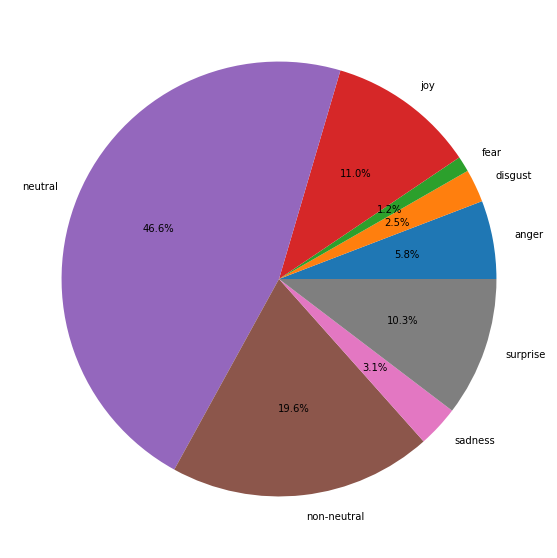

In [15]:
import matplotlib.pyplot as plt
from numpy import unique

labels, frequencies = unique(test_df.emotion.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

In [ ]:
# from sklearn.model_selection import train_test_split
# # lets combine + shuffle train and val and then split again.
# combined_df = pd.concat([train_df, val_df])
# train_df, val_df = train_test_split(combined_df, test_size=0.2, shuffle=True, 
#                                     stratify=combined_df['emotion'], random_state=seed)

In [ ]:
# create the labels as integers
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
train_df['label'] = labelEncoder.fit_transform(train_df['emotion'].values)
train_df.drop(['emotion'], axis='columns', inplace=True)

val_df['label'] = labelEncoder.transform(val_df['emotion'].values)
val_df.drop(['emotion'], axis='columns', inplace=True)

test_df['label'] = labelEncoder.transform(test_df['emotion'].values)
test_df.drop(['emotion'], axis='columns', inplace=True)

num_classes=len(labelEncoder.classes_)
labelEncoder.classes_

array(['anger', 'disgust', 'fear', 'joy', 'neutral', 'non-neutral',
       'sadness', 'surprise'], dtype=object)

In [ ]:
# you can figure out the mapping like this:
example_label = 3
print("Label:", labelEncoder.classes_[example_label])
example_label = 6
print("Label:", labelEncoder.classes_[example_label])

Label: joy
Label: sadness


In [ ]:
train_df.sample(5)

,index,utterance,label
265,10495,Monica says: Is that all?,4
8996,3357,"Ross says: Oh, thank you.",4
1251,3880,"Joey says: Look at that, every inch of this st...",7
6142,2111,Susan says: See what you did.,5
5797,4131,Cliff says: Are all the questions this personal?,7


In [ ]:
max_len = -1
for _,row in train_df.iterrows():
  length = len(row.utterance)
  if length > max_len:
    max_len = length

max_len

340



> If you prefer using tf.data.Datasets, then you can convert with the code below



In [ ]:
import tensorflow as tf
from numpy import array
print(tf.__version__)
tf.random.set_seed(seed)

# train_ds = tf.data.Dataset.from_tensor_slices(
#         (
#             tf.cast(train_df['utterance'].values, tf.string),
#             tf.cast(train_df['label'].values, tf.int16)
#         )
#      )

# val_ds = tf.data.Dataset.from_tensor_slices(
#         (
#             tf.cast(val_df['utterance'].values, tf.string),
#             tf.cast(val_df['label'].values, tf.int16)
#         )
#      )

# test_ds = tf.data.Dataset.from_tensor_slices(
#         (
#             tf.cast(test_df['utterance'].values, tf.string),
#             tf.cast(test_df['label'].values, tf.int16)
#         )
#      )

def prep_data(df):
    
    texts = []
    labels = []

    for _,row in df.iterrows():
      texts.append(row.utterance)
      labels.append(row.label)

    return array(texts), array(labels)

2.3.0


In [ ]:
x_train, y_train = prep_data(train_df)
x_val, y_val = prep_data(val_df)
x_test, y_test = prep_data(test_df)

y_true = y_test

y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# Embedding

In [ ]:
import tensorflow_hub as hub
hub.__version__

'0.8.0'

In [ ]:
# embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"
# embedding = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
# embedding = "https://tfhub.dev/google/Wiki-words-500/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=False)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
Total params: 124,644,888
Trainable params: 2,200
Non-trainable params: 124,642,688
_________________________________________________________________


In [ ]:
import tensorflow_addons as tfa

In [ ]:
f1_score = tfa.metrics.F1Score(num_classes, average='micro', name='f1')   # this is the competition metric

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),    # default learning rate
              loss=tfa.losses.SigmoidFocalCrossEntropy(), 
              metrics=[f1_score])

In [ ]:
filepath = 'model.h5'
mc = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto')
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto', restore_best_weights=False)

history = model.fit(x_train, y_train, epochs=100, verbose=1, 
                    validation_data=(x_val, y_val), callbacks=[mc, es])

Epoch 1/100
331/331 [==============================] - 4s 12ms/step - loss: 0.3251 - f1: 0.4127 - val_loss: 0.3209 - val_f1: 0.4160
Epoch 2/100
331/331 [==============================] - 4s 12ms/step - loss: 0.2965 - f1: 0.4491 - val_loss: 0.3155 - val_f1: 0.4194
Epoch 3/100
331/331 [==============================] - 4s 11ms/step - loss: 0.2912 - f1: 0.4522 - val_loss: 0.3123 - val_f1: 0.4185
Epoch 4/100
331/331 [==============================] - 4s 11ms/step - loss: 0.2861 - f1: 0.4565 - val_loss: 0.3091 - val_f1: 0.4270
Epoch 5/100
331/331 [==============================] - 5s 16ms/step - loss: 0.2821 - f1: 0.4638 - val_loss: 0.3064 - val_f1: 0.4270
Epoch 6/100
331/331 [==============================] - 6s 19ms/step - loss: 0.2788 - f1: 0.4672 - val_loss: 0.3037 - val_f1: 0.4338
Epoch 7/100
331/331 [==============================] - 7s 22ms/step - loss: 0.2762 - f1: 0.4764 - val_loss: 0.3024 - val_f1: 0.4304
Epoch 8/100
331/331 [==============================] - 6s 18ms/step - loss: 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


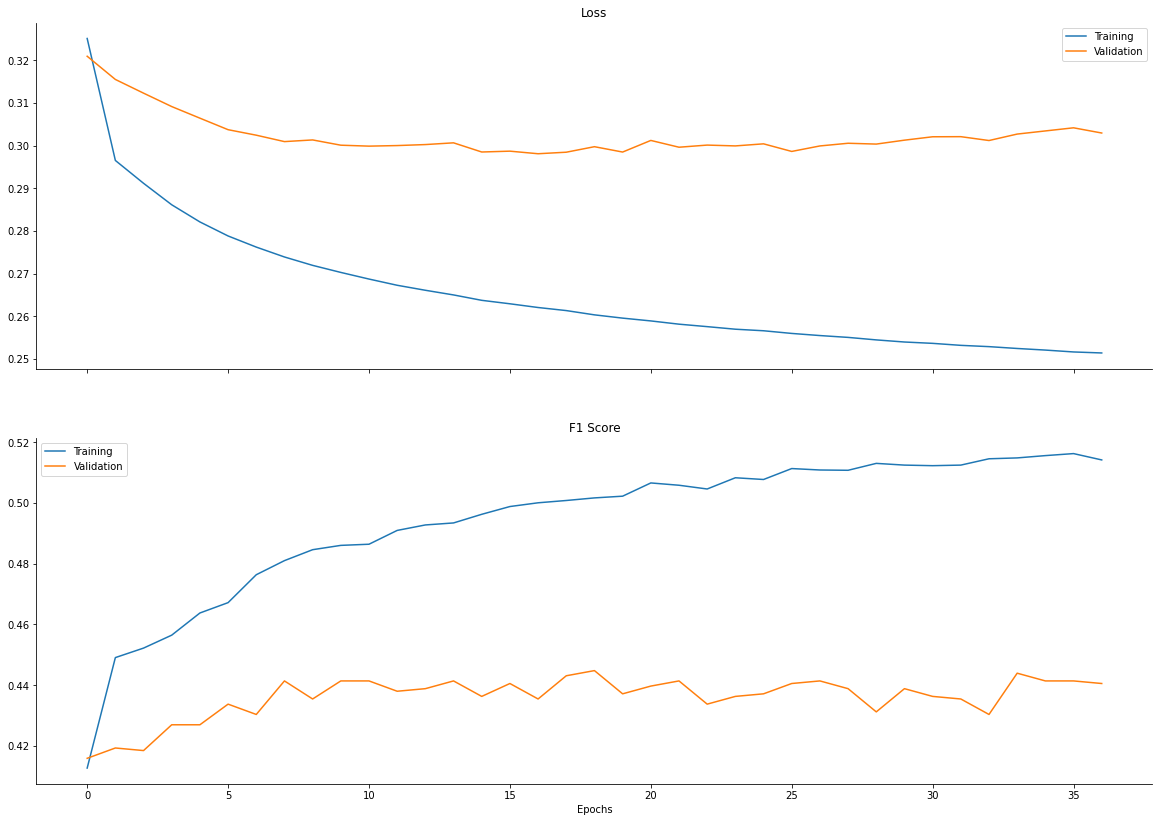

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Training')
ax1.plot(history['val_loss'], label='Validation')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['f1'], label='Training')
ax2.plot(history['val_f1'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('F1 Score')

plt.xlabel('Epochs')
sns.despine()
plt.show()

Now lets Fine tune the model.

In [ ]:
model.load_weights(filepath)
model.get_layer(name='keras_layer').trainable = True
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
Total params: 124,644,888
Trainable params: 124,644,888
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # note the reduced learning_rate
              loss=tfa.losses.SigmoidFocalCrossEntropy(), 
              metrics=[f1_score])

In [ ]:
history = model.fit(x_train, y_train, epochs=500, verbose=1, 
                    validation_data=(x_val, y_val), callbacks=[mc, es],
                    )

Epoch 1/500
331/331 [==============================] - 13s 40ms/step - loss: 0.2597 - f1: 0.4970 - val_loss: 0.2975 - val_f1: 0.4406
Epoch 2/500
331/331 [==============================] - 13s 40ms/step - loss: 0.2580 - f1: 0.5079 - val_loss: 0.2969 - val_f1: 0.4423
Epoch 3/500
331/331 [==============================] - 13s 40ms/step - loss: 0.2563 - f1: 0.5103 - val_loss: 0.2964 - val_f1: 0.4440
Epoch 4/500
331/331 [==============================] - 13s 40ms/step - loss: 0.2547 - f1: 0.5133 - val_loss: 0.2959 - val_f1: 0.4440
Epoch 5/500
331/331 [==============================] - 13s 40ms/step - loss: 0.2532 - f1: 0.5161 - val_loss: 0.2954 - val_f1: 0.4448
Epoch 6/500
331/331 [==============================] - 13s 40ms/step - loss: 0.2516 - f1: 0.5186 - val_loss: 0.2949 - val_f1: 0.4465
Epoch 7/500
331/331 [==============================] - 13s 40ms/step - loss: 0.2501 - f1: 0.5217 - val_loss: 0.2944 - val_f1: 0.4482
Epoch 8/500
331/331 [==============================] - 13s 40ms/step 

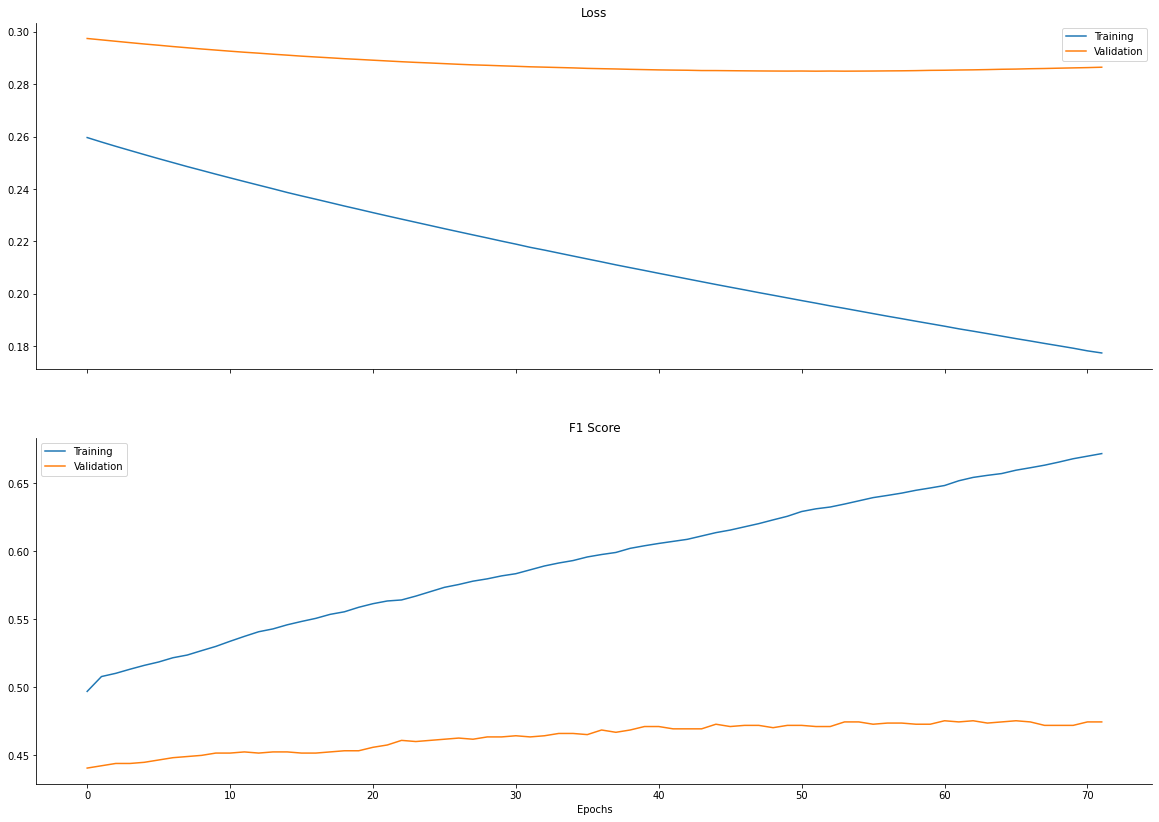

In [ ]:
history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Training')
ax1.plot(history['val_loss'], label='Validation')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['f1'], label='Training')
ax2.plot(history['val_f1'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('F1 Score')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [ ]:
model.load_weights(filepath)
model.evaluate(x_test, y_test, verbose=1)

87/87 [==============================] - 0s 4ms/step - loss: 0.2549 - f1: 0.5246


[0.2548649311065674, 0.5246020555496216]

In [ ]:
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=1)

Let's look at how we did on each class.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=labelEncoder.classes_))

              precision    recall  f1-score   support

       anger       0.20      0.01      0.01       161
     disgust       0.00      0.00      0.00        68
        fear       0.00      0.00      0.00        32
         joy       0.49      0.43      0.46       304
     neutral       0.57      0.86      0.68      1287
 non-neutral       0.31      0.18      0.23       541
     sadness       0.40      0.05      0.08        85
    surprise       0.49      0.38      0.43       286

    accuracy                           0.52      2764
   macro avg       0.31      0.24      0.24      2764
weighted avg       0.45      0.52      0.46      2764



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Competition prediction task



> In the competition they only predict samples with joy, sadness, anger, and neutral. All others are discarded. 



In [ ]:
allowed_emotions = ['joy', 'sadness', 'anger', 'neutral']

df = pd.read_json('friends_train.json')
utterances = []
emotions = []
for _, row in df.iterrows():
  for i in range(len(df.columns)):
    if row[i] is not None and row[i]['emotion'] in allowed_emotions:
      speaker = row[i]['speaker']
      utterance = row[i]['utterance'].replace('\x92', '`')
      utterances.append(speaker + ' says: ' + utterance)
      emotions.append(row[i]['emotion'])

train_df = pd.DataFrame(list(zip(utterances, emotions)), 
               columns =['utterance', 'emotion']) 

df = pd.read_json('friends_dev.json')
utterances = []
emotions = []
for _, row in df.iterrows():
  for i in range(len(df.columns)):
    if row[i] is not None and row[i]['emotion'] in allowed_emotions:
      speaker = row[i]['speaker']
      utterance = row[i]['utterance'].replace('\x92', '`')
      utterances.append(speaker + ' says: ' + utterance)
      emotions.append(row[i]['emotion'])

val_df = pd.DataFrame(list(zip(utterances, emotions)), 
               columns =['utterance', 'emotion'])

df = pd.read_json('friends_test.json')
utterances = []
emotions = []
for _, row in df.iterrows():
  for i in range(len(df.columns)):
    if row[i] is not None and row[i]['emotion'] in allowed_emotions:
      speaker = row[i]['speaker']
      utterance = row[i]['utterance'].replace('\x92', '`')
      utterances.append(speaker + ' says: ' + utterance)
      emotions.append(row[i]['emotion'])

test_df = pd.DataFrame(list(zip(utterances, emotions)), 
               columns =['utterance', 'emotion'])

In [ ]:
train_df['emotion'].value_counts()

neutral    4752
joy        1283
anger       513
sadness     351
Name: emotion, dtype: int64

In [ ]:
# from sklearn.model_selection import train_test_split
# # lets combine + shuffle train and val and then split again.
# combined_df = pd.concat([train_df, val_df])
# train_df, val_df = train_test_split(combined_df, test_size=0.2, shuffle=True, 
#                                     stratify=combined_df['emotion'], random_state=seed)

In [ ]:
# create the labels as integers
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
train_df['label'] = labelEncoder.fit_transform(train_df['emotion'].values)
train_df.drop(['emotion'], axis='columns', inplace=True)

val_df['label'] = labelEncoder.transform(val_df['emotion'].values)
val_df.drop(['emotion'], axis='columns', inplace=True)

test_df['label'] = labelEncoder.transform(test_df['emotion'].values)
test_df.drop(['emotion'], axis='columns', inplace=True)

num_classes=len(labelEncoder.classes_)
labelEncoder.classes_

array(['anger', 'joy', 'neutral', 'sadness'], dtype=object)

In [ ]:
max_len = -1
for _,row in train_df.iterrows():
  length = len(row.utterance)
  if length > max_len:
    max_len = length

max_len

256

In [ ]:
import tensorflow as tf
tf.random.set_seed(seed)

In [ ]:
x_train, y_train = prep_data(train_df)
x_val, y_val = prep_data(val_df)
x_test, y_test = prep_data(test_df)

y_true = y_test

y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

In [ ]:
import tensorflow_hub as hub

embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=False)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
Total params: 124,644,820
Trainable params: 2,132
Non-trainable params: 124,642,688
_________________________________________________________________


In [ ]:
import tensorflow_addons as tfa

In [ ]:
f1_score = tfa.metrics.F1Score(num_classes, average='micro', name='f1')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tfa.losses.SigmoidFocalCrossEntropy(), 
              metrics=[f1_score])

In [ ]:
filepath = 'model.h5'
mc = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto')
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto', restore_best_weights=False)

history = model.fit(x_train, y_train, epochs=100, verbose=1, 
                    validation_data=(x_val, y_val), callbacks=[mc, es])

Epoch 1/100
216/216 [==============================] - 3s 15ms/step - loss: 0.1770 - f1: 0.6669 - val_loss: 0.1809 - val_f1: 0.6452
Epoch 2/100
216/216 [==============================] - 3s 13ms/step - loss: 0.1598 - f1: 0.6907 - val_loss: 0.1776 - val_f1: 0.6452
Epoch 3/100
216/216 [==============================] - 3s 14ms/step - loss: 0.1558 - f1: 0.6949 - val_loss: 0.1744 - val_f1: 0.6544
Epoch 4/100
216/216 [==============================] - 3s 15ms/step - loss: 0.1527 - f1: 0.6969 - val_loss: 0.1728 - val_f1: 0.6597
Epoch 5/100
216/216 [==============================] - 4s 18ms/step - loss: 0.1503 - f1: 0.7021 - val_loss: 0.1714 - val_f1: 0.6610
Epoch 6/100
216/216 [==============================] - 6s 29ms/step - loss: 0.1484 - f1: 0.7072 - val_loss: 0.1710 - val_f1: 0.6702
Epoch 7/100
216/216 [==============================] - 1s 7ms/step - loss: 0.1467 - f1: 0.7066 - val_loss: 0.1712 - val_f1: 0.6610
Epoch 8/100
216/216 [==============================] - 5s 23ms/step - loss: 0

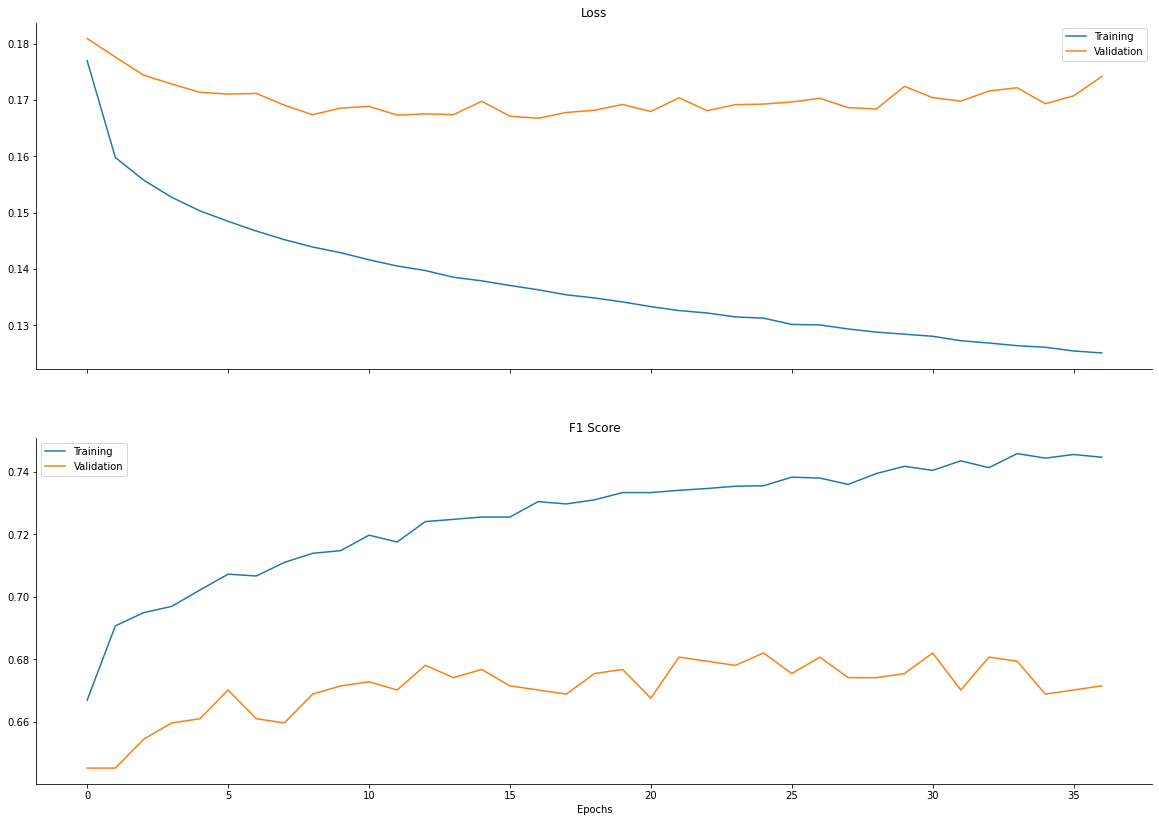

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Training')
ax1.plot(history['val_loss'], label='Validation')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['f1'], label='Training')
ax2.plot(history['val_f1'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('F1 Score')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [ ]:
model.load_weights(filepath)
model.get_layer(index=0).trainable = True
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
Total params: 124,644,820
Trainable params: 124,644,820
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), 
              loss=tfa.losses.SigmoidFocalCrossEntropy(), 
              metrics=[f1_score])

In [ ]:
history = model.fit(x_train, y_train, epochs=500, verbose=1, 
                    validation_data=(x_val, y_val), callbacks=[mc, es],
                    )

Epoch 1/500
216/216 [==============================] - 8s 36ms/step - loss: 0.1342 - f1: 0.7258 - val_loss: 0.1668 - val_f1: 0.6702
Epoch 2/500
216/216 [==============================] - 8s 36ms/step - loss: 0.1341 - f1: 0.7317 - val_loss: 0.1667 - val_f1: 0.6715
Epoch 3/500
216/216 [==============================] - 8s 36ms/step - loss: 0.1339 - f1: 0.7317 - val_loss: 0.1667 - val_f1: 0.6715
Epoch 4/500
216/216 [==============================] - 9s 42ms/step - loss: 0.1337 - f1: 0.7318 - val_loss: 0.1667 - val_f1: 0.6728
Epoch 5/500
216/216 [==============================] - 9s 42ms/step - loss: 0.1337 - f1: 0.7324 - val_loss: 0.1667 - val_f1: 0.6728
Epoch 6/500
216/216 [==============================] - 9s 42ms/step - loss: 0.1335 - f1: 0.7327 - val_loss: 0.1667 - val_f1: 0.6728
Epoch 7/500
216/216 [==============================] - 9s 42ms/step - loss: 0.1333 - f1: 0.7329 - val_loss: 0.1667 - val_f1: 0.6728
Epoch 8/500
216/216 [==============================] - 9s 42ms/step - loss: 

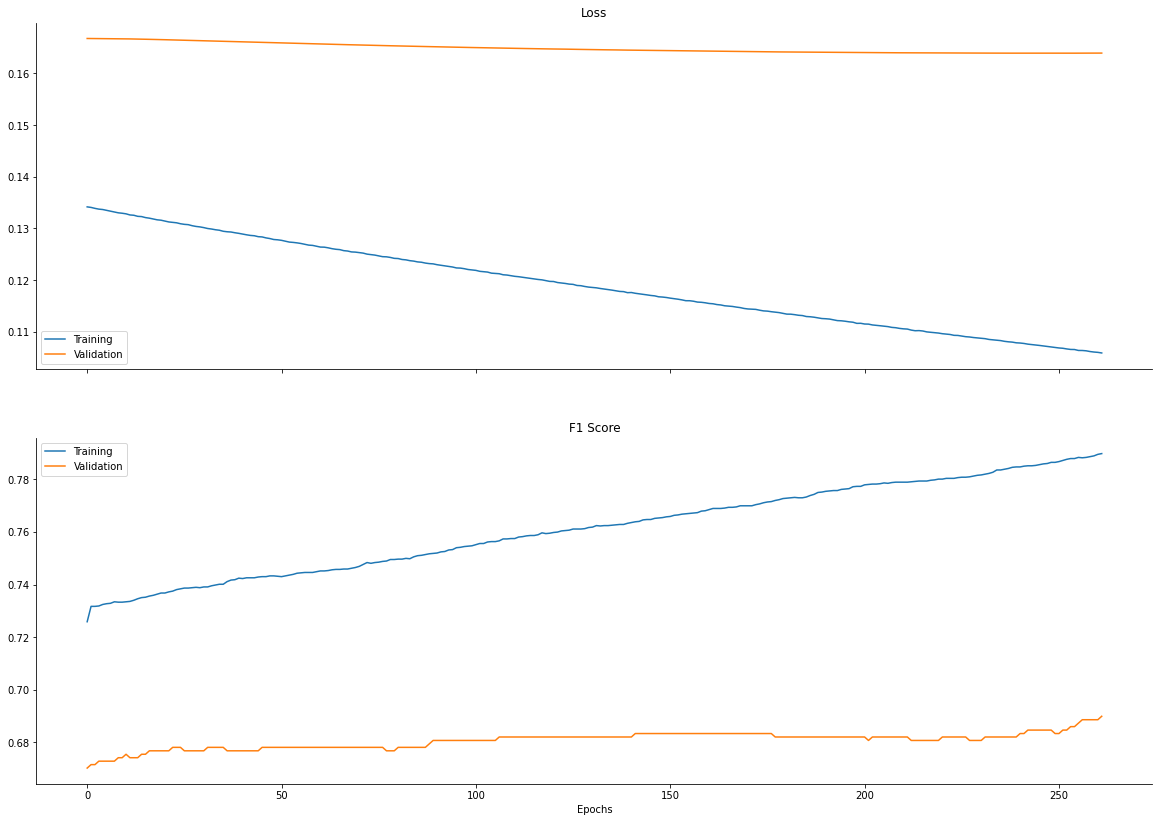

In [ ]:
history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Training')
ax1.plot(history['val_loss'], label='Validation')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['f1'], label='Training')
ax2.plot(history['val_f1'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('F1 Score')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [ ]:
model.load_weights(filepath)
model.evaluate(x_test, y_test, verbose=1)

58/58 [==============================] - 0s 5ms/step - loss: 0.1380 - f1: 0.7447


[0.13796909153461456, 0.7446925044059753]

In [ ]:
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=1)

In [ ]:
print(classification_report(y_true, y_pred, target_names=labelEncoder.classes_))

              precision    recall  f1-score   support

       anger       0.41      0.04      0.08       161
         joy       0.65      0.44      0.53       304
     neutral       0.76      0.95      0.84      1287
     sadness       0.55      0.07      0.12        85

    accuracy                           0.74      1837
   macro avg       0.59      0.38      0.39      1837
weighted avg       0.70      0.74      0.69      1837

